<a href="https://colab.research.google.com/github/Gocoderunav/Understanding-Non-linear-Dynamics-in-Fiber-optics-Through-Physics-Informed-Neural-Network-PINN-/blob/main/nlse_ssfm_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

In [ ]:
# Calculate absolute difference between SSFM and PINNs results
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [ ]:

x_lower = -24   # will put time values in this
x_upper = 24
t_lower = 0   # will put x values in it
t_upper = 2

beta_2 =-1 # 2nd order dispersion (s^2/km)
N = 2  # Soliton number

gamma =1
# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 960)
t = np.linspace(t_lower, t_upper, 400)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)



In [ ]:

def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t - (beta_2)*0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t + (beta_2)*0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [ ]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return N / np.cosh(x[:, 0:1])

#  for five wave use this

# def init_cond_u(x):
#     "2 sech(x)"
#     return np.exp(-(x[:,0:1] +15)**2) + np.exp(-(x[:,0:1] +7)**2) + np.exp(-(x[:,0:1])**2) +np.exp(-(x[:,0:1]-7)**2) + np.exp(-(x[:,0:1] - 15)**2)


#  for Dark Soliton (when beta_2 is Positive)
# def init_cond_u(x):
#     "2 sech(x)"
#     return  np.tanh(x[:, 0:1])


# the inmaginary part is zero initailly
def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.076860 s

'compile' took 1.247157 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.31e-03, 7.98e-03, 2.40e-02, 6.20e-06, 1.26e-01, 3.47e-06, 1.82e-01, 3.23e-02]    [1.31e-03, 7.98e-03, 2.40e-02, 6.20e-06, 1.26e-01, 3.47e-06, 1.82e-01, 3.23e-02]    []  
1000      [2.82e-03, 3.47e-03, 9.04e-07, 1.26e-06, 1.79e-06, 3.24e-08, 6.19e-03, 4.51e-04]    [2.82e-03, 3.47e-03, 9.04e-07, 1.26e-06, 1.79e-06, 3.24e-08, 6.19e-03, 4.51e-04]    []  
2000      [2.90e-03, 2.88e-03, 1.70e-07, 8.61e-07, 4.70e-08, 4.03e-07, 3.71e-03, 3.92e-04]    [2.90e-03, 2.88e-03, 1.70e-07, 8.61e-07, 4.70e-08, 4.03e-07, 3.71e-03, 3.92e-04]    []  
3000      [2.41e-03, 2.50e-03, 1.42e-07, 7.17e-07, 4.65e-07, 2.76e-07, 2.71e-03, 1.78e-04]    [2.41e-03, 2.50e-03, 1.42e-07, 7.17e-

(<deepxde.model.LossHistory at 0x79166b84aa70>,
 <deepxde.model.TrainState at 0x79166b84aec0>)

In [ ]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=500,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 1.234177 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [9.63e-04, 9.95e-04, 1.24e-05, 1.71e-08, 1.31e-05, 1.27e-08, 4.82e-05, 1.22e-05]    [9.63e-04, 9.95e-04, 1.24e-05, 1.71e-08, 1.31e-05, 1.27e-08, 4.82e-05, 1.22e-05]    []  
11000     [2.05e-05, 1.98e-05, 1.31e-08, 3.17e-08, 6.31e-09, 4.93e-08, 1.61e-06, 7.17e-07]    [2.05e-05, 1.98e-05, 1.31e-08, 3.17e-08, 6.31e-09, 4.93e-08, 1.61e-06, 7.17e-07]        
12000     [6.29e-06, 6.41e-06, 4.50e-09, 8.57e-09, 3.25e-09, 9.92e-09, 2.48e-07, 1.31e-07]    [6.29e-06, 6.41e-06, 4.50e-09, 8.57e-09, 3.25e-09, 9.92e-09, 2.48e-07, 1.31e-07]        
13000     [2.92e-06, 2.78e-06, 1.50e-08, 7.04e-09, 8.61e-11, 6.24e-09, 1.08e-07, 1.09e-07]    [2.92e-06, 2.78e-06, 1.50e-08, 7.04e-09, 8.61e-11, 6.24e-09, 1.08e-07, 1.09e-07]        
14000     [1.

(<deepxde.model.LossHistory at 0x79166b84aa70>,
 <deepxde.model.TrainState at 0x79166b84aec0>)

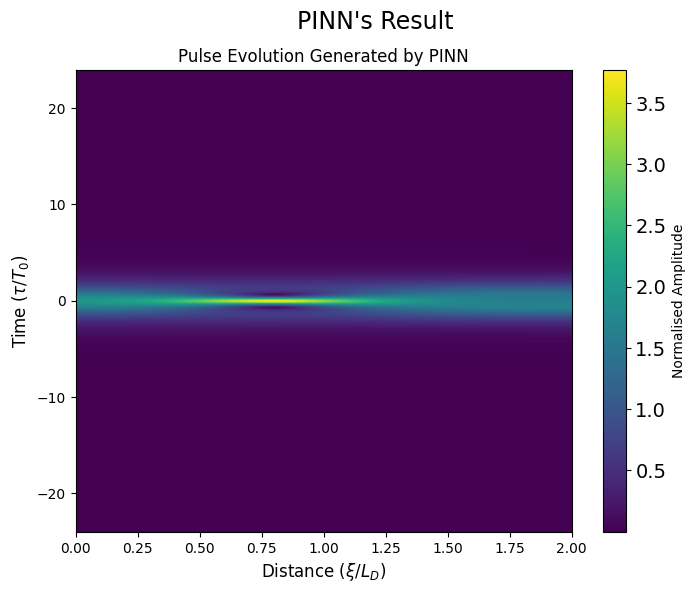

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
h = np.sqrt(u ** 2 + v ** 2)

# Plot the amplitude
fig, ax = plt.subplots(figsize=(8, 6))
im1 = ax.imshow(h.T, cmap="viridis", extent=[t_lower, t_upper, x_lower, x_upper], origin="lower", aspect="auto", vmin=np.min(h), vmax=np.max(h))

ax.set_xlabel('Distance ($\\xi / L_D$)', fontsize=12)
ax.set_ylabel('Time ($\\tau / T_0$)', fontsize=12)

ax.set_title('Pulse Evolution Generated by PINN', fontsize=12)

# Corrected setting for colorbar label size
cbar = fig.colorbar(im1, ax=ax, label="Normalised Amplitude")
cbar.ax.tick_params(labelsize=14)

# Add main heading
fig.suptitle("PINN's Result", fontsize=17)

plt.show()







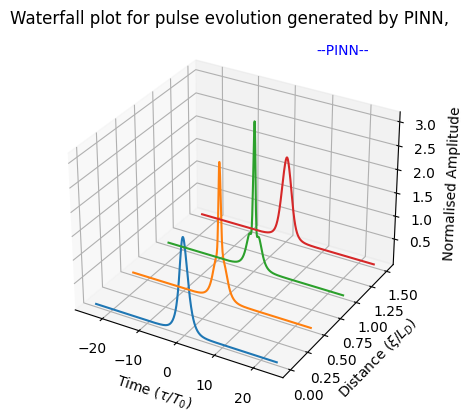

In [ ]:
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate over T and plot h vs X for every 100th value of T
for i in range(0, len(T), 100):
    if i == 0:
        ax.plot(X[0], np.full_like(X[0], T[i]), h[i], ls='solid', label='PINN')
    else:
        ax.plot(X[0], np.full_like(X[0], T[i]), h[i], ls='solid')

# Set labels and title

ax.set_xlabel('Time ($\\tau / T_0$)',)
ax.set_ylabel('Distance ($\\xi / L_D$)')
ax.set_zlabel('Normalised Amplitude')
plt.title('Waterfall plot for pulse evolution generated by PINN, ')




ax.text2D(0.8, 0.95, '--PINN--', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,color ='Blue')


ax.grid(True)

plt.show()



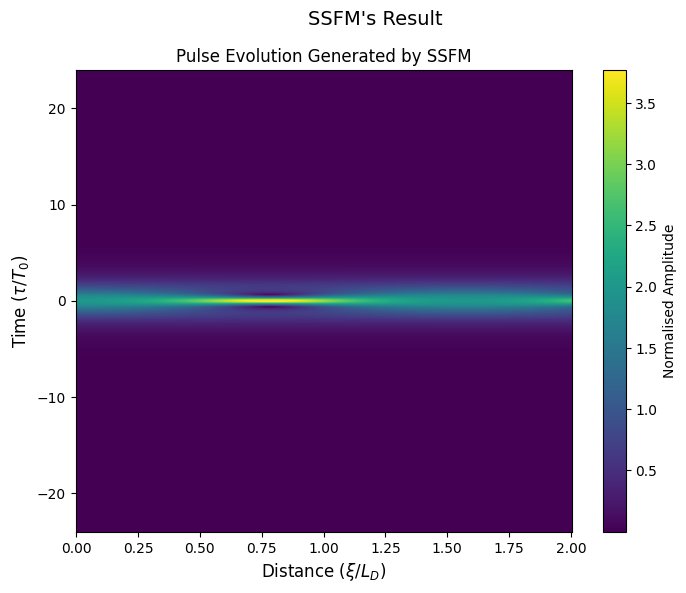

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# Material parameters


# Time parameters
delta_t = 0.05
T_ssfm = np.linspace(-24, 24, 960)

# Input pulse and its parameters
T_0 = 1  # Initial pulse width (s)
P_0 = 1  # Input power (Watts)
A_0 = np.sqrt(P_0)  # Normalization factor

h_step = 0.005  # Step size for z
z_plot = np.linspace(0, 2, 400)  # z-values to plot in km
z_0 = 2  # Soliton period in km

# for N=1 and N=2
A = N * (1 / np.cosh(T_ssfm / T_0))


# for five wave
# A = (np.exp(-(T_ssfm + 15)**2) + np.exp(-(T_ssfm + 7)**2) + np.exp(-T_ssfm**2) +
#      np.exp(-(T_ssfm - 7)**2) + np.exp(-(T_ssfm - 15)**2))

# for Dark Soliton
# A = N**2 * np.tanh(T_ssfm / T_0)

L = len(A)
Delta_omega = 1 / L / delta_t * 2 * np.pi
omega = np.arange(-L // 2, L // 2) * Delta_omega

A_f = np.fft.fftshift(np.fft.fft(A))  # Pulse in frequency domain
A_t = np.fft.ifft(A_f)  # Pulse in time domain

# Set initial condition for the imaginary part
A_t = A_t.real + 0j  # Imaginary part set to zero initially

plotting = np.zeros((len(T_ssfm), len(z_plot)), dtype=np.complex128)

for jj, z in enumerate(np.arange(h_step, z_0 + h_step, h_step)):
    A_f = A_f * np.exp(1j * beta_2 / 2 * omega**2 * (h_step / 2))
    A_t = np.fft.ifft(A_f)  # Pulse in time domain
    A_t = A_t * np.exp(1j * (np.abs(A_t)**2) * gamma * h_step)
    A_f = np.fft.fft(A_t)
    A_f = A_f * np.exp(1j * beta_2 / 2 * omega**2 * (h_step / 2))
    A_t = np.fft.ifft(A_f)

    # Normalize the solution
    A_t = A_t / A_0

    # Store the intensity values in the plotting array
    plotting[:, jj] = np.abs(A_t)

    # Implement periodic boundary conditions
    A_t = np.concatenate((A_t[-L//4:], A_t, A_t[:L//4]))


fig, ax = plt.subplots(figsize=(8, 6))
im2 = ax.pcolormesh(z_plot, T_ssfm, np.abs(plotting), cmap='viridis', shading='auto', vmin=np.min(h), vmax=np.max(h))

ax.set_xlabel('Distance ($\\xi / L_D$)', fontsize=12)
ax.set_ylabel('Time ($\\tau / T_0$)', fontsize=12)
ax.set_title('Pulse Evolution Generated by SSFM', fontsize=12)

fig.colorbar(im2, ax=ax, label='Normalised Amplitude')
ax.grid(False)
fig.suptitle("SSFM's Result", fontsize=14)
plt.show()

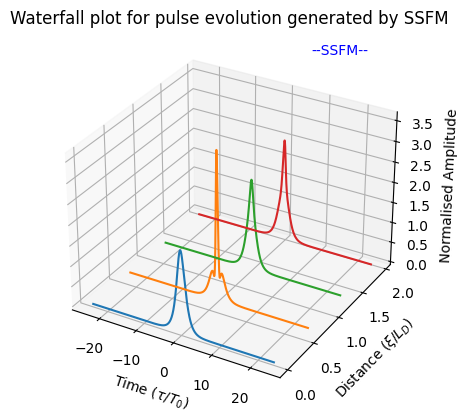

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for k in range(0, len(z_plot), 130):
    if k == 0:
        y = np.full_like(T_ssfm, z_plot[k])
        ax.plot(T_ssfm, y, plotting[:, k], linewidth=1.5, ls='solid', label='SSFM')
    else:
        y = np.full_like(T_ssfm, z_plot[k])
        ax.plot(T_ssfm, y, plotting[:, k], linewidth=1.5)

ax.set_xlabel('Time ($\\tau / T_0$)', fontsize=10)
ax.set_ylabel('Distance ($\\xi / L_D$)', fontsize=10)
ax.set_zlabel('Normalised Amplitude ', fontsize=10)
plt.title('Waterfall plot for pulse evolution generated by SSFM')

# Move the legend to a suitable position
# ax.legend(loc='upper right')

ax.text2D(0.8, 0.95, '--SSFM--', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,color ='Blue')
plt.show()


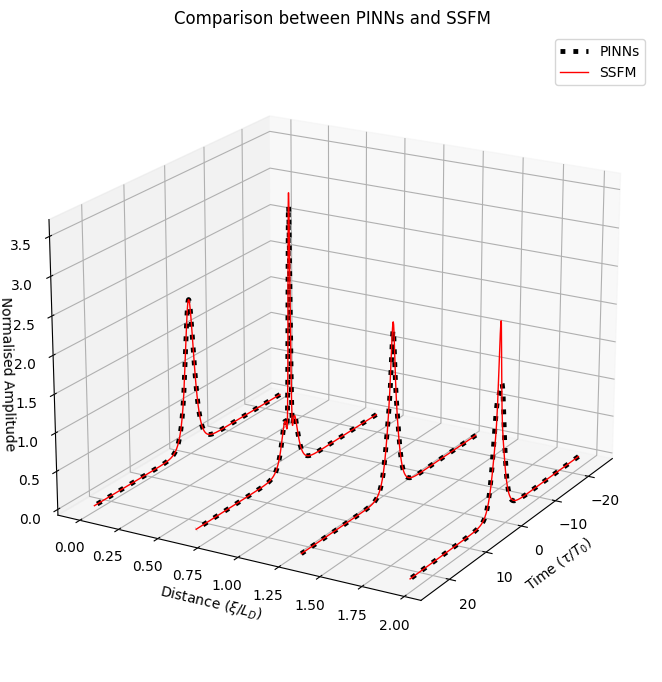

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot with adjusted margins
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Adjust margins as needed

# Iterate over T and plot h vs X for every 100th value of T
for i in range(0, len(T), 130):
    if i == 0:
        ax.plot(X[0], np.full_like(X[0], T[i]), np.abs(h[i]), lw=3.5, ls=':', label='PINNs', color='black')

        y = np.full_like(T_ssfm, z_plot[i*len(z_plot)//len(T)])
        ax.plot(T_ssfm, y, np.abs(plotting[:, i*len(z_plot)//len(T)]), linewidth=1, ls='solid', label='SSFM', color='red')
    else:
        ax.plot(X[0], np.full_like(X[0], T[i]), np.abs(h[i]), lw=3.5, ls=':', color='black')

        y = np.full_like(T_ssfm, z_plot[i*len(z_plot)//len(T)])
        ax.plot(T_ssfm, y, np.abs(plotting[:, i*len(z_plot)//len(T)]), linewidth=1, ls='solid', color='red')

# Set labels and title
ax.set_xlabel('Time ($\\tau / T_0$)')
ax.set_ylabel('Distance ($\\xi / L_D$)', fontsize=10)

ax.set_zlabel('Normalised Amplitude', labelpad=-2)  # Increase labelpad to adjust the distance from the axis
plt.title('Comparison between PINNs and SSFM')

ax.legend()
ax.grid(True)

# Adjust the view to better visualize the z-label
ax.view_init(elev=20, azim=30)

plt.show()


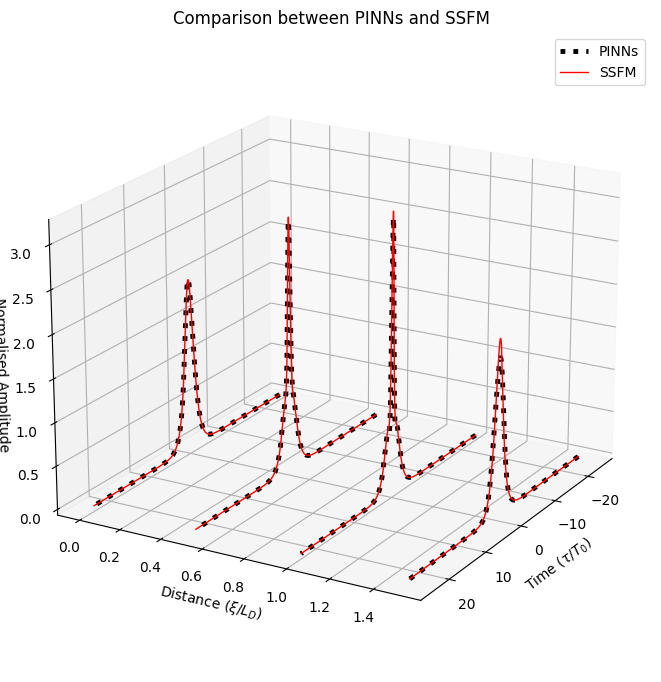

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot with adjusted margins
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Adjust margins as needed

# Iterate over T and plot h vs X for every 100th value of T
for i in range(0, len(T), 100):
    if i == 0:
        ax.plot(X[0], np.full_like(X[0], T[i]), np.abs(h[i]), lw=3.5, ls=':', label='PINNs', color='black')

        y = np.full_like(T_ssfm, z_plot[i*len(z_plot)//len(T)])
        ax.plot(T_ssfm, y, np.abs(plotting[:, i*len(z_plot)//len(T)]), linewidth=1, ls='solid', label='SSFM', color='red')
    else:
        ax.plot(X[0], np.full_like(X[0], T[i]), np.abs(h[i]), lw=3.5, ls=':', color='black')

        y = np.full_like(T_ssfm, z_plot[i*len(z_plot)//len(T)])
        ax.plot(T_ssfm, y, np.abs(plotting[:, i*len(z_plot)//len(T)]), linewidth=1, ls='solid', color='red')

# Set labels and title
ax.set_xlabel('Time ($\\tau / T_0$)')
ax.set_ylabel('Distance ($\\xi / L_D$)')
ax.set_zlabel('Normalised Amplitude', labelpad=0)  # Set z-axis label to "Amplitude"
plt.title('Comparison between PINNs and SSFM')

ax.legend()
ax.grid(True)

# Adjust the view to better visualize the z-label
ax.view_init(elev=20, azim=30)

plt.show()


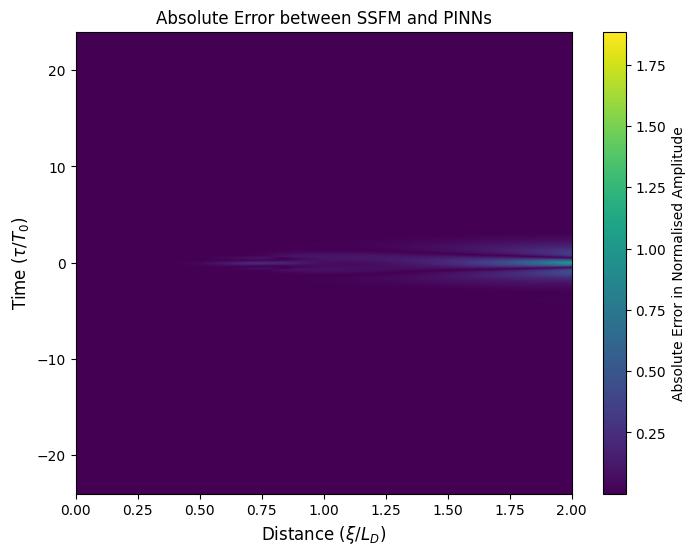

In [ ]:
# Calculate absolute difference between SSFM and PINNs results
error = np.abs(h.T - plotting)

# Plot the error density plot
plt.figure(figsize=(8, 6))
plt.imshow(error, cmap='viridis', extent=[t_lower, t_upper, x_lower, x_upper], origin='lower', aspect='auto',vmin=np.min(h)*(3e-2), vmax=np.max(h)*(5e-1))
plt.colorbar(label='Absolute Error in Normalised Amplitude')
plt.xlabel('Distance ($\\xi / L_D$)', fontsize=12)
plt.ylabel('Time ($\\tau / T_0$)', fontsize=12)
plt.title('Absolute Error between SSFM and PINNs', fontsize=12)
plt.show()
